In [25]:
%cd /data/ajay/contracode
%pwd
!pip uninstall -y pandas
!pip install pandas sklearn scipy matplotlib seaborn numpy plotnine altair

/data/ajay/contracode
Found existing installation: pandas 1.1.2
Uninstalling pandas-1.1.2:
  Successfully uninstalled pandas-1.1.2
  Using cached pandas-1.1.2-cp38-cp38-manylinux1_x86_64.whl (10.4 MB)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

modin 0.8.0 requires pandas==1.0.5, but you'll have pandas 1.1.2 which is incompatible.
datasets 1.0.2 requires pyarrow>=0.17.1, but you'll have pyarrow 0.16.0 which is incompatible.


In [56]:
import pickle
import numpy as np
import plotnine as p9
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import altair as alt

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [75]:
moco_path = "data/tsne/tsne_out_embedded_grouped_hidden.pickle"
!ls -lah {moco_path}
with open(moco_path, 'rb') as f:
    x = f.read()
    in_tsne_embeddings = pickle.loads(x)

-rw-rw-r--+ 1 ajay ajay 18M Sep 30 00:34 data/tsne/tsne_out_embedded_grouped_hidden.pickle


In [60]:
matches = [
 ('init', 282),
 ('parse', 242),
 ('get', 186),
 ('create', 181),
 ('validate', 145),
 ('run', 144),
 ('update', 128),
 ('extend', 127),
 ('merge', 111),
 ('set', 109),
 ('render', 105),
 ('transform', 103),
 ('resolve', 100),
 ('main', 99),
 ('request', 98),
 ('log', 98),
 ('add', 95),
 ('load', 93),
 ('format', 90),
 ('client', 90),
 ('compile', 87),
 ('start', 87),
 ('find', 84),
 ('normalize', 83),
 ('clone', 81)]

In [88]:
def compute_tsne_dict(data, include=None, isolate_color=None, n_iter=10000, perplexity=50, mean=True):
    all_data = []
    labels = []
    for item in data:
        if include is None or item['func_name'] in include:
            label = item['func_name'] if isolate_color is None or item['func_name'] in isolate_color else 'Other'
            labels.append(label)
            all_data.append(item['embedding'])

    tsne = TSNE(n_iter=n_iter, perplexity=perplexity, n_jobs=-1, learning_rate=25.)
    if mean:
        z = [x.mean(0) for x in all_data]
    else:
        z = [x.flatten() for x in all_data]
    tsne_results = tsne.fit_transform(z)
    out_data = []
    for (x, y), label in zip(tsne_results, labels):
        out_data.append(dict(x=x, y=y, label=str(label)))
    df = pd.DataFrame(out_data)
    # plot = p9.ggplot(p9.aes('x', 'y'), df) + p9.geom_point(p9.aes(color='label'), alpha=0.8) + p9.theme_classic()
    return df

not_grey_list = ['validate', 'normalize', 'compile']
df = compute_tsne_dict(in_tsne_embeddings, include=[x[0] for x in matches], isolate_color=not_grey_list,
                       n_iter=4000, perplexity=32, mean=True)

alt.Chart(df).mark_circle(size=60).encode(
    x='x',
    y='y',
    color='label',
    tooltip=['label']
).interactive()

alt.Chart(...)

# Flat embedding file

In [47]:
moco_path = "data/tsne/moco_embed_tsne_embeddings.pickle"
!ls -lah {moco_path}
with open(moco_path, 'rb') as f:
    x = f.read()
    in_tsne_embeddings_file = pickle.loads(x)

-rw-rw-r--+ 1 ajay ajay 134M Sep 29 22:06 data/tsne/moco_embed_tsne_embeddings.pickle


CPU times: user 4min 1s, sys: 4.53 s, total: 4min 6s
Wall time: 7.38 s


NameError: name 'tsne_results' is not defined

64 

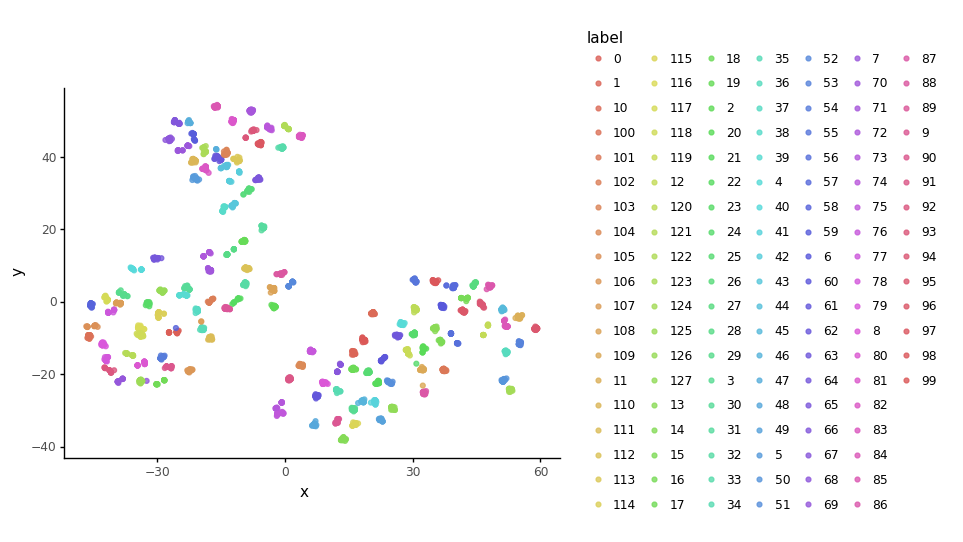

<ggplot: (8746474126270)>


In [84]:
filtered_embeddings = [[np.asarray(z[1]) for z in x if z is not None] for x in in_tsne_embeddings_file]
sorted_embeddings = sorted(filtered_embeddings, key=lambda x: len(x))[-128:]
top20_samples = sorted_embeddings

def compute_tsne(data, exclude=[], n_iter=10000, perplexity=50, mean=True):
    all_data = []
    labels = []
    for group_idx, group in enumerate(data):
        labels.extend([group_idx] * len(group))
        all_data.extend(group)

    tsne = TSNE(n_iter=n_iter, perplexity=perplexity, n_jobs=-1, early_exaggeration=5.)
    if mean:
        z = [x.mean(0).mean(0) for x in all_data]
    else:
        z = [x.flatten() for x in all_data]
    
    tsne_results = tsne.fit_transform(z)
    out_data = []
    for (x, y), label in zip(tsne_results, labels):
        out_data.append(dict(x=x, y=y, label=str(label)))
    df = pd.DataFrame(out_data)
    plot = p9.ggplot(p9.aes('x', 'y'), df) + p9.geom_point(p9.aes(color='label'), alpha=0.8) + p9.theme_classic()
    return df, plot

for perp in [64]:
    %time plot = compute_tsne(top20_samples, n_iter=1000, perplexity=perp, mean=False)[1]
    print(perp, plot)